In [1]:
import numpy as np
import matplotlib.pyplot as plt
import aipy as a 
import capo
import capo.miriad as miriad
#import capo.omni as omni
from copy import deepcopy
import glob
from pyuvdata import UVCal
from pyuvdata import UVData
from hera_cal import omni
from hera_cal import firstcal
%matplotlib notebook 

In [2]:
datafile = '/data4/paper/HERA2015/2457545/zen.2457545.48011.xx.HH.uvc' #apparent degeneracy problems
#datafile = '/data4/paper/HERA2015/2457757/zen.2457757.47316.xx.HH.uvc' #works well

#datafile = '/data4/paper/HERA2015/2457757/zen.2457757.59147.xx.HH.uvc' #some weird times

#datafile = '/data4/paper/HERA2015/2457765/zen.2457765.49404.xx.HH.uvc' #bad firstcal


#datafile = '/data4/paper/HERA2015/2457790/zen.2457790.25046.xx.HH.uvc' #very bad firstcal
#datafile = '/data4/paper/HERA2015/2457757/zen.2457757.59147.xx.HH.uvc' # sometimes bad
#datafile = '/data4/paper/HERA2015/2457757/zen.2457757.58451.xx.HH.uvc' #works well
datafile = '/data4/paper/HERA2015/2457750/zen.2457750.16693.xx.HH.uvc'

datafile = '/data4/paper/HERA2015/2457678/zen.2457678.26437.xx.HH.uvc' #for aaron


pol = datafile.split('.HH.')[0].split('.')[-1]
ORdatafile = datafile.replace('/zen','/IDR1/zen') + 'OR'
badantfile = datafile.replace('/zen','/IDR1/zen') + '.badants.txt'
firstcalfile = datafile.replace('/zen','/IDR1/zen') + '.first.calfits'
try: xants = list(np.loadtxt(badantfile, delimiter=','))
except: xants = [int(np.loadtxt(badantfile, delimiter=','))]
#meta,data,flags = miriad.read_files([datafile],'cross',pol)




print 'xants:',xants
xants = []
meta,data,flags = miriad.read_files([datafile],'cross',pol)
metaOR,dataOR,flagsOR = miriad.read_files([ORdatafile],'cross',pol)

xants: [81]


In [6]:
freqs = meta['freqs']
aa = a.cal.get_aa('hsa7458_v001', freqs)
info = omni.aa_to_info(aa, pols=[pol[0]], ex_ants=xants, crosspols=[pol])


reds = info.get_reds()

<IPython.core.display.Javascript object>


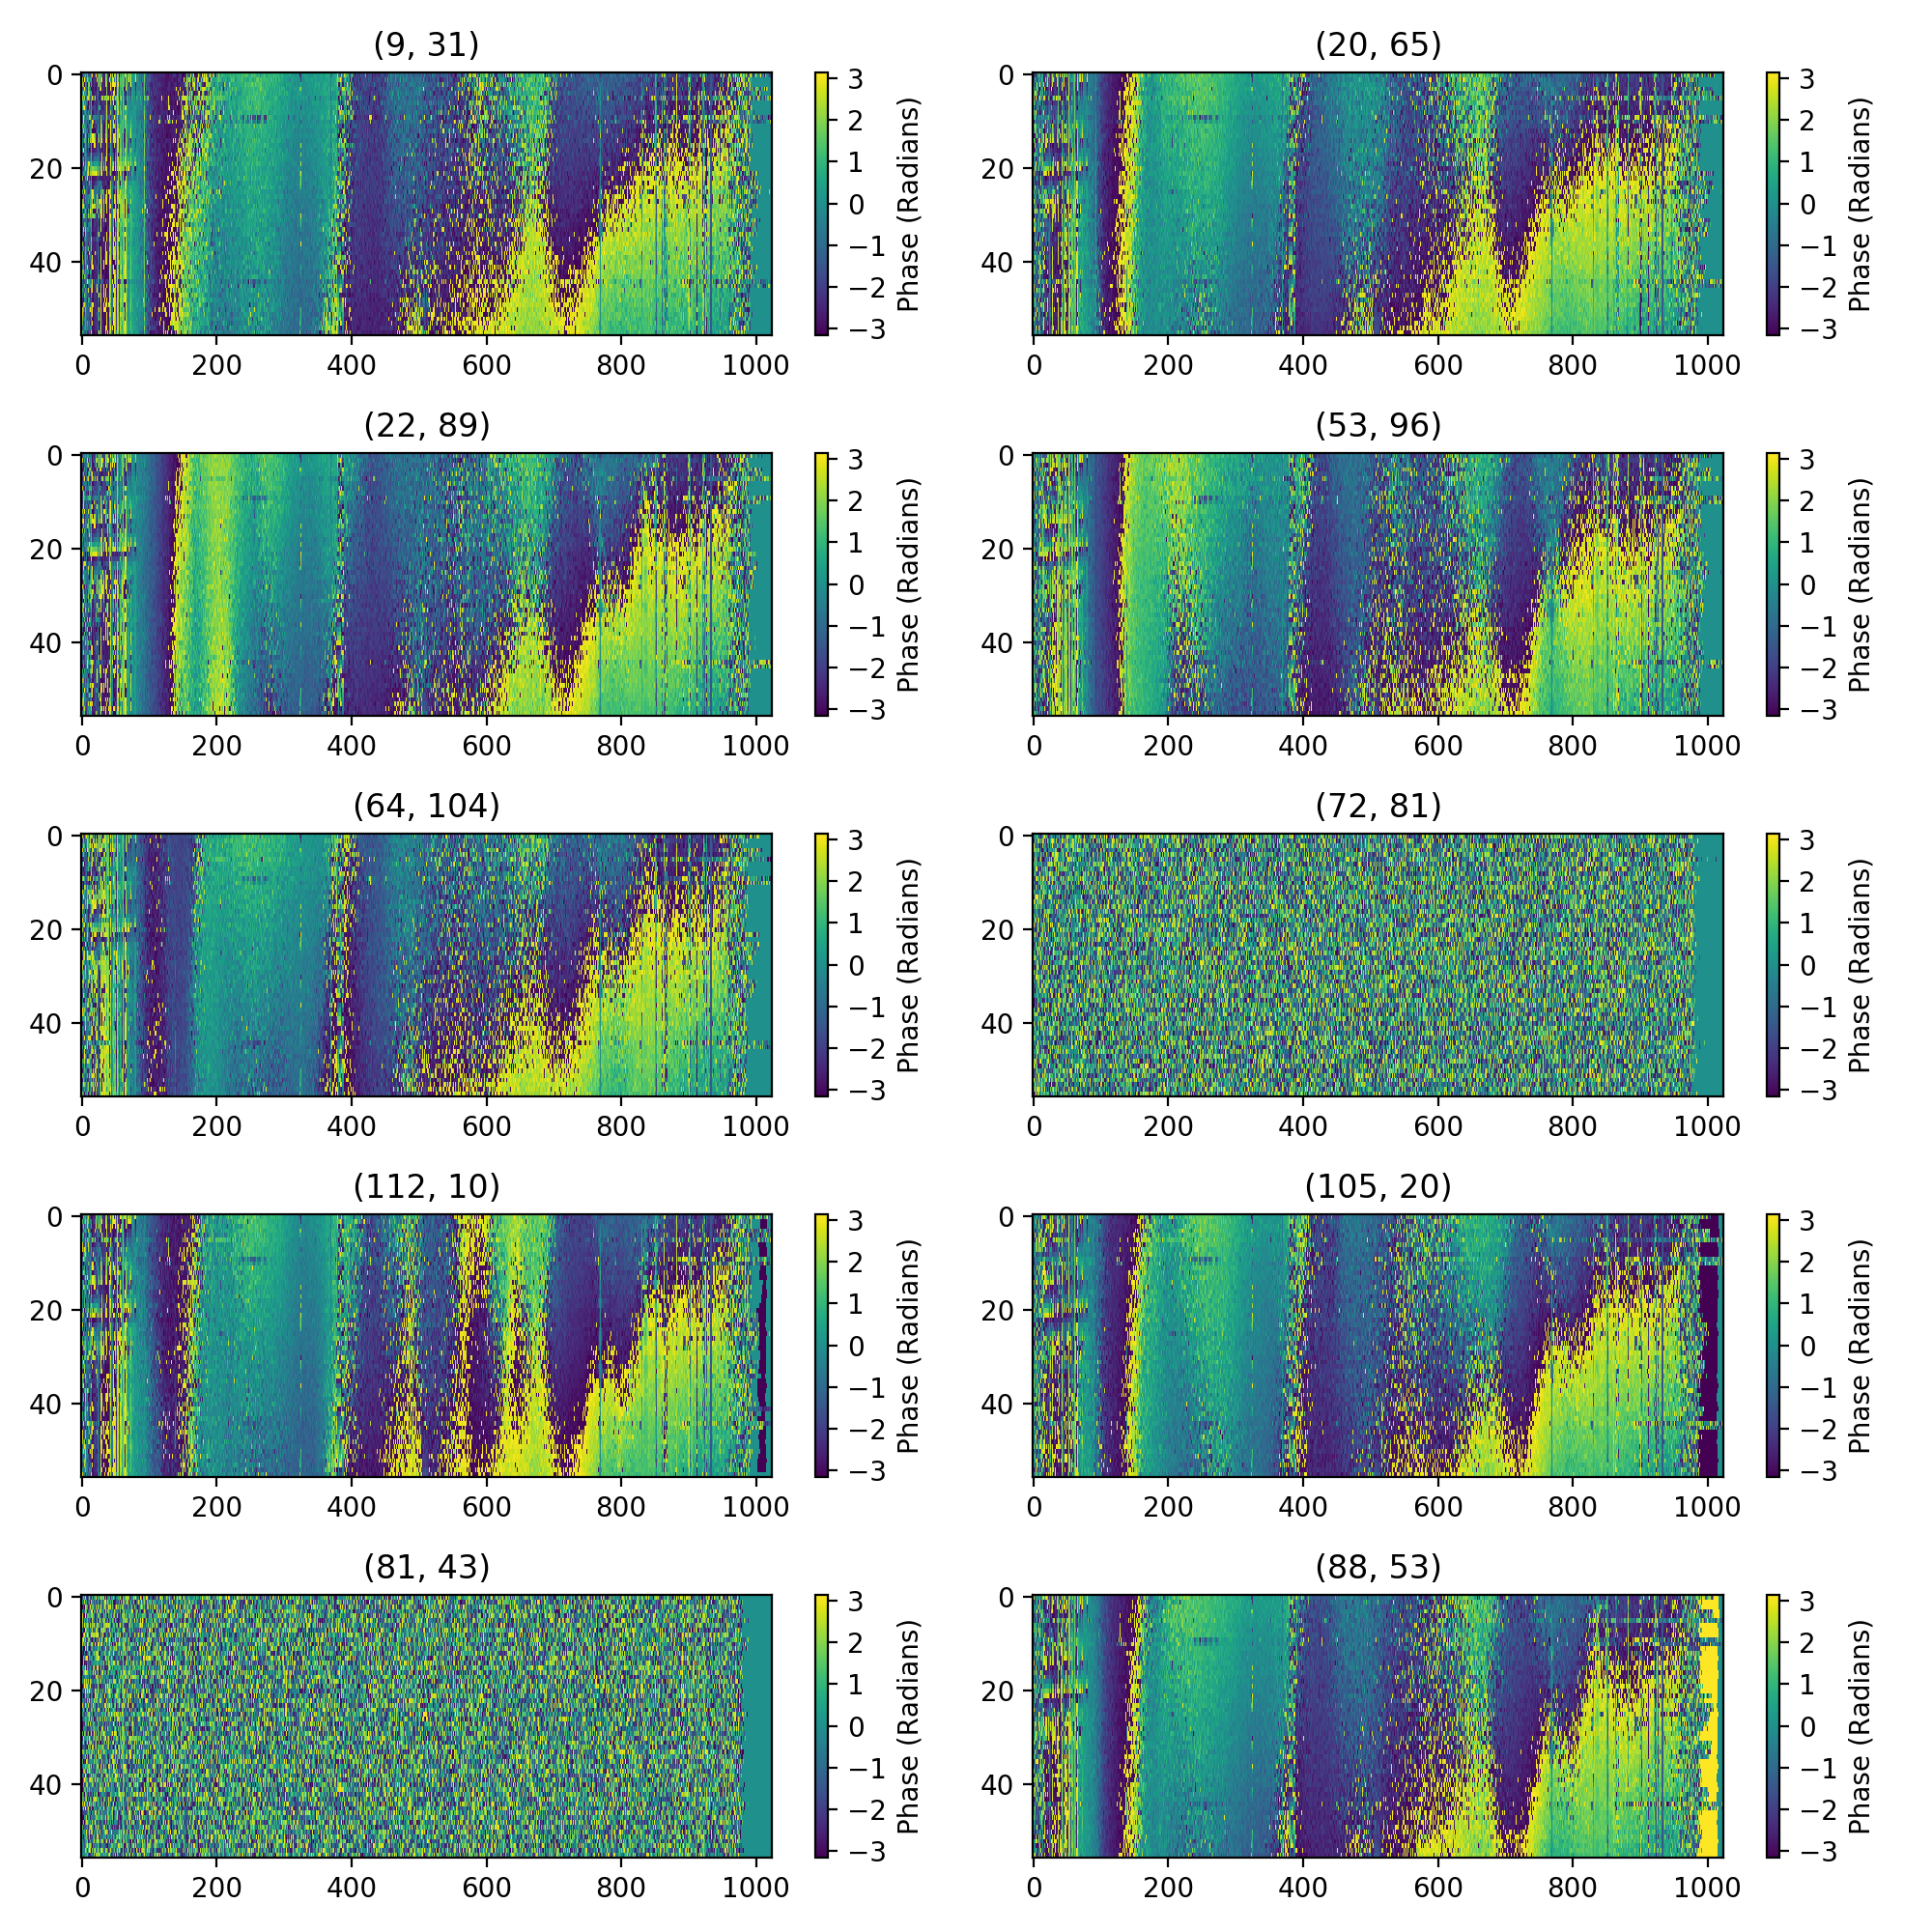

In [7]:
from matplotlib.colors import LogNorm

red = reds[0]
fig, axes = plt.subplots(5,2,figsize=(10,10))
axes = [item for sublist in axes for item in sublist]
for n,bl in enumerate(red):
    plt.sca(axes[n])
    try:
#        plt.imshow(np.abs(data[bl][pol]), aspect='auto', norm=LogNorm())
        capo.plot.waterfall(dataOR[bl][pol], mode='phs',  mx=np.pi, drng=2*np.pi)
    except: 
#        plt.imshow(np.abs(np.conj(data[(bl[1],bl[0])][pol])), aspect='auto', norm=LogNorm())
        capo.plot.waterfall(np.conj(dataOR[(bl[1],bl[0])][pol]), mode='phs',  mx=np.pi, drng=2*np.pi)
    plt.colorbar(label='Phase (Radians)')
    plt.title(bl)
plt.tight_layout()


# Explore Check_Ants

In [5]:
from heracal.metrics import DataContainer

def check_ants2(reds, data, flag_sigma=2.5, min_corr = .6, skip_ants=[]):
    dc = DataContainer(data)
    badants_result = {}
    for pol in dc.pols():
        bad_ants = [] + list(skip_ants)
        while True:
            reds = [[bl for bl in bls if bl[0] not in bad_ants and bl[1] not in bad_ants] for bls in reds]
            all_bls = reduce(lambda x,y: x+y, reds)
            auto_pwr, ant2col = {}, {}
            for bl in dc.bls(pol).intersection(all_bls):
                d = dc.get(bl,pol)
                auto_pwr[bl] = np.median(np.sum(np.abs(d)**2, axis=0))
            ants = list(set([ant for bl in all_bls for ant in bl]))
            corrs = {ant: [] for ant in ants}
            for bls in reds:
                bls = list(dc.bls(pol).intersection(bls))
                for i,bl1 in enumerate(bls):
                    d1 = dc.get(bl1,pol)
                    for j,bl2 in enumerate(bls[i+1:]):
                        d2 = dc.get(bl2,pol)
                        pwr12 = np.median(np.abs(np.sum(d1*d2.conj(), axis=0)))
                        corr = pwr12 / np.sqrt(auto_pwr[bl1] * auto_pwr[bl2])
                        for bl in [bl1,bl2]:
                            for ant in bl: corrs[ant] += [corr]
            ants = corrs.keys()
            means = [np.median(corrs[ant]) for ant in ants]
            lowMeans = ((means - np.mean(means)) / np.std(means) < -flag_sigma) + (np.array(means)<min_corr)
            isMinMean = means == np.min(means)
            toExclude = list(np.array(ants)[lowMeans * isMinMean])
            if len(toExclude) == 0: break
            bad_ants += toExclude
        badants_result[pol] = bad_ants
    return badants_result
        

    

badants_result = check_ants2(reds, data, flag_sigma=2.5, min_corr = .8)
print badants_result

{'xx': [81, 96, 112, 80, 104, 31]}


In [6]:
data.values()[0].keys()

['xx']

In [7]:
JD = 2457750 #sometimes good day
JD = 2457757 #good day
JD = 2457545
pol = 'xx'
alldatafiles = glob.glob('/data4/paper/HERA2015/'+str(JD)+'/*'+pol+'.HH.uvc')
for datafile in alldatafiles:
    badantfile = datafile.replace('/zen','/IDR1/zen') + '.badants.txt'
    try: badants = list(np.loadtxt(badantfile, delimiter=','))
    except: badants = [int(np.loadtxt(badantfile, delimiter=','))]
    meta,data,flags = miriad.read_files([datafile],'cross',pol)
    freqs = meta['freqs']
    aa = a.cal.get_aa('hsa7458_v001', freqs)
    info = omni.aa_to_info(aa, pols=[pol[0]], ex_ants=xants, crosspols=[pol])
    reds = info.get_reds()
    badants_result = check_ants2(reds, data, flag_sigma=2.5, min_corr = .6)
    print datafile.split('/')[-1].split(pol)[0], badants, badants_result

zen.2457545.66106. [81] {'xx': [81]}
zen.2457545.65410. [81] {'xx': [81, 43]}
zen.2457545.64714. [81] {'xx': [81]}
zen.2457545.64018. [81] {'xx': [81, 112, 80]}
zen.2457545.62626. [81] {'xx': [81]}
zen.2457545.63322. [81] {'xx': [81, 112]}
zen.2457545.61930. [81] {'xx': [81]}
zen.2457545.61234. [81] {'xx': [81, 96]}
zen.2457545.60538. [81] {'xx': [81]}
zen.2457545.59842. [81] {'xx': [81, 96, 53]}
zen.2457545.59147. [81] {'xx': [81, 96]}
zen.2457545.58451. [81] {'xx': [81, 96]}
zen.2457545.57755. [81] {'xx': [81]}
zen.2457545.57059. [81] {'xx': [81]}
zen.2457545.56363. [81] {'xx': [81]}
zen.2457545.54971. [81] {'xx': [81]}
zen.2457545.53579. [81] {'xx': [81]}
zen.2457545.52883. [81] {'xx': [81]}
zen.2457545.52187. [81] {'xx': [81]}
zen.2457545.51491. [81] {'xx': [81]}
zen.2457545.50795. [81] {'xx': [81]}
zen.2457545.50099. [81] {'xx': [81, 112]}
zen.2457545.48011. [81] {'xx': [81, 112]}
zen.2457545.47315. [81] {'xx': [81]}
zen.2457545.45924. [81] {'xx': [81, 112]}
zen.2457545.44532. [81

# Run Firstcal 

In [8]:
xants = [81, 43, 97]
#datafile = '/data4/paper/HERA2015/2457545/zen.2457545.35484.xx.HH.uvc'
xants = [22,96,81]
datafile = '/data4/paper/HERA2015/2457750/zen.2457750.16693.xx.HH.uvc'



def runFC(filename, xants):
    # read in data and run firstcal
    
    badantfile = datafile.replace('/zen','/IDR1/zen') + '.badants.txt'
    try: badants = list(np.loadtxt(badantfile, delimiter=','))
    except: badants = [int(np.loadtxt(badantfile, delimiter=','))]
    print("Reading {0}".format(filename)), badants
    uv_in = UVData()
    uv_in.read_miriad(filename)
    if uv_in.phase_type != 'drift':
        print("Setting phase type to drift")
        uv_in.unphase_to_drift()
    datapack, wgtpack = omni.UVData_to_dict([uv_in])
    wgtpack = {k: {p: np.logical_not(wgtpack[k][p]) for p in wgtpack[k]} for k in wgtpack}  # logical_not of wgtpack

    infoFC = omni.aa_to_info(aa, fcal=True, pols=[pol[0]], ex_ants=xants, crosspols=[pol])

    # gets phase solutions per frequency.
    fc = firstcal.FirstCal(datapack, wgtpack, freqs, infoFC)
    sols = fc.run(finetune=True, verbose=False, average=False, window='none')
    return sols

sols0 = runFC(filename, [])
sols1 = runFC(filename, [81])
sols2 = runFC(filename, xants)

NameError: name 'filename' is not defined

In [ ]:
plt.figure()
for key in sols2.keys():
    plt.plot(1e9*np.array(sols0[key])[0],':', label=key)
    plt.plot(1e9*np.array(sols1[key])[0], label=key)
    plt.plot(1e9*np.array(sols2[key])[0],'--', label=key)

# Examining Firstcal Solutions

In [14]:
JD = 2457765 #bad day
JD = 2457764
#JD = 2457757 #sometimes good day
#JD = 2457750 #sometimes good day
#JD = 2457742 #mostly good day
#JD = 2457790 #bad day
#JD = 2457545

pol = 'xx'
firstcalfiles = glob.glob('/data4/paper/HERA2015/'+str(JD)+'/IDR1/*'+pol+'.HH.uvc.first.calfits')
print len(firstcalfiles), 'files found.'

72 files found.


In [15]:
import warnings
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    times = np.array([])
    delays = {}
    for fcfile in firstcalfiles:
        UV = UVCal()
        UV.read_calfits(fcfile)
        times=np.append(times,UV.time_array)
        for n,ant in enumerate(UV.ant_array):
            if delays.has_key(ant): delays[ant] = np.append(delays[ant], 1e9*UV.delay_array[n,0,:,0])
            else: delays[ant] = 1e9*UV.delay_array[n,0,:,0]



<IPython.core.display.Javascript object>


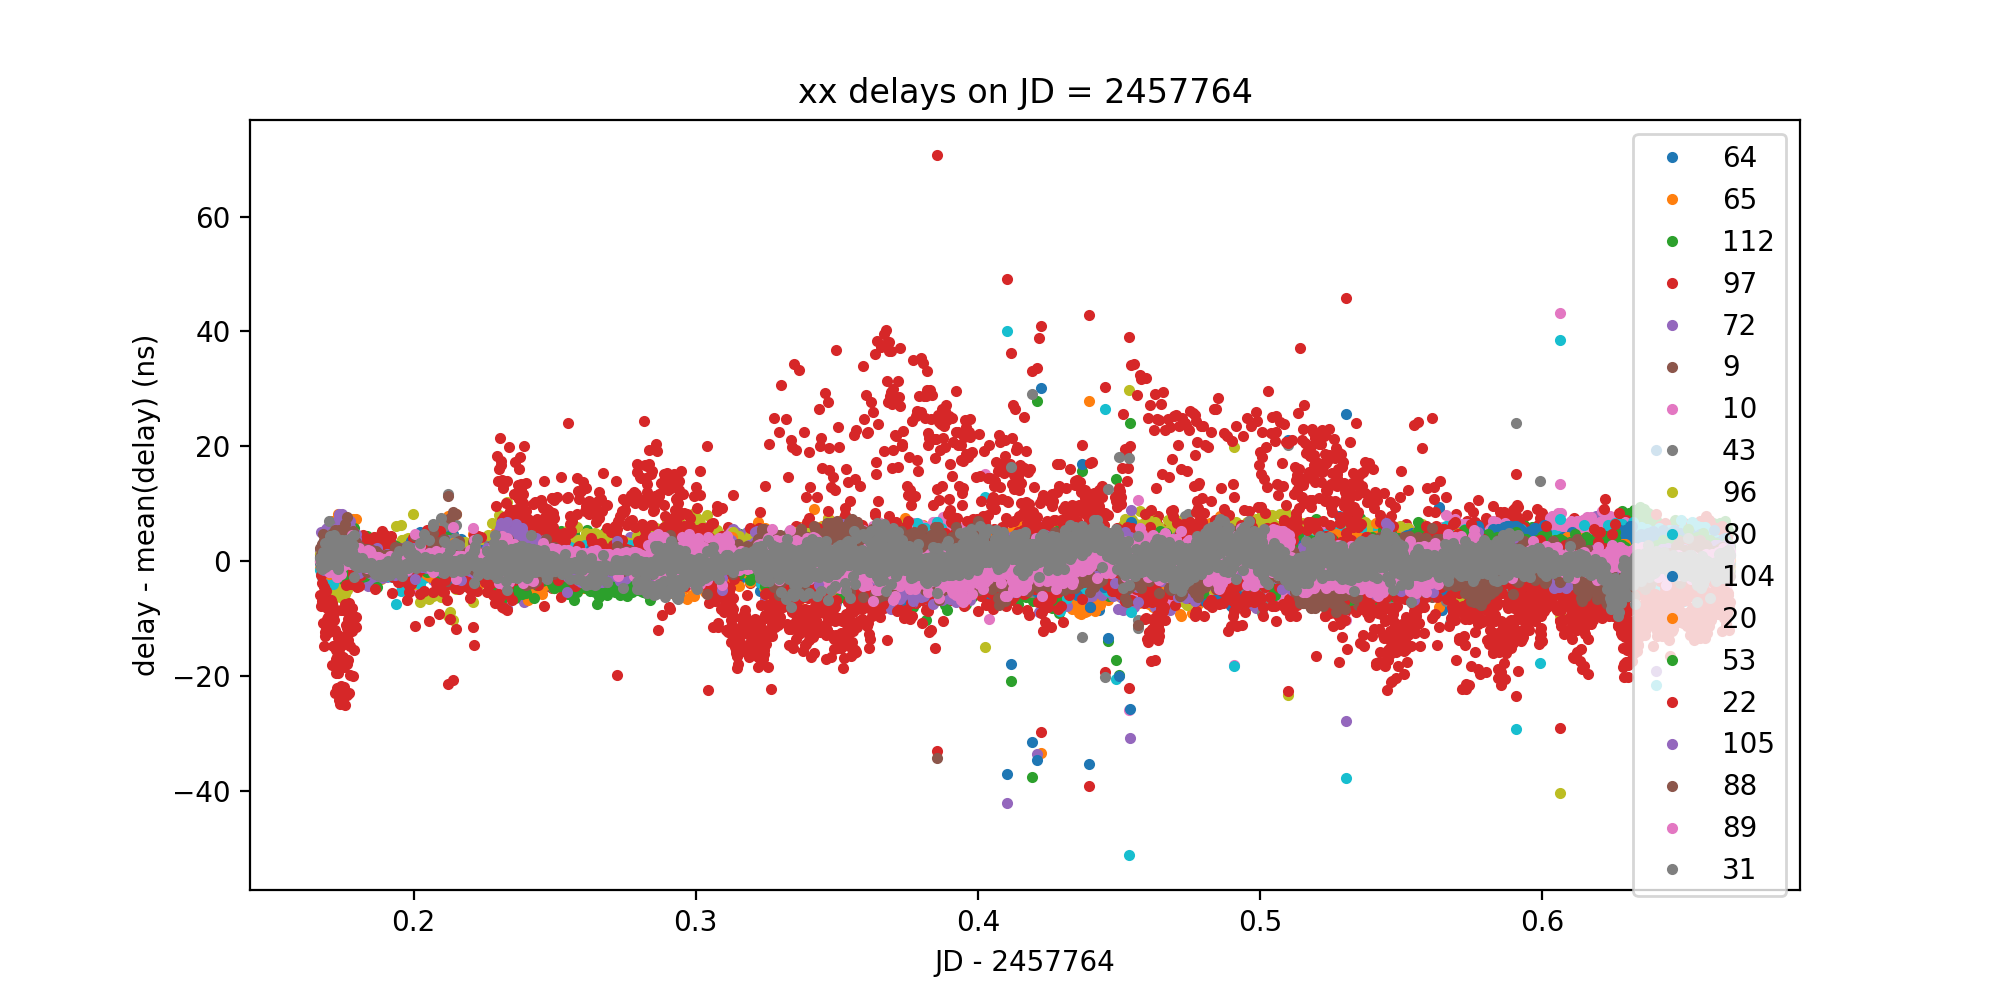

In [16]:
plt.figure(figsize=(10,5))
for ant,delay in delays.items():
    #if ant==22 or ant==64 or ant==9: 
    plt.plot(times-JD, delay-np.mean(delay),'.', label=ant)
    #plt.plot(times-JD, delay,'.', label=ant)
plt.legend(loc='best',fontsize=10)
plt.xlabel('JD - '+str(JD)); plt.ylabel('delay - mean(delay) (ns)')
plt.title(pol + ' delays on JD = ' + str(JD))

In [ ]:
firstcalfiles

In [ ]:
# badantsFiles = glob.glob('/data4/paper/HERA2015/*/IDR1/*.badants.txt')
# badants = {file.split('.badants.txt')[0]: np.array(np.loadtxt(file, delimiter=',')) for file in badantsFiles}

In [ ]:
# yset, xset = set(), set()
# for key,val in badants.items():
#     if key.find('.xx.')>0: 
#         try: xset.add(tuple(val))
#         except: xset.add(int(val))
# for key,val in badants.items():
#     if key.find('.yy.')>0: 
#         try: yset.add(tuple(val))
#         except: yset.add(int(val))

        
# print 'xx:', xset
# print 'yy:', yset

In [ ]:
# for key,val in badants.items():
#     if key.find('.yy.')>0: 
#         try: 
#             if tuple(val) == (81.0, 22.0, 64.0): print key, key.split('.')[2]
#         except: 
#             pass

In [ ]:
print len(glob.glob('/data4/paper/HERA2015/24577*/*.xy.HH.uvc'))
print len(glob.glob('/data4/paper/HERA2015/24577*/*.xx.HH.uvc'))
print len(glob.glob('/data4/paper/HERA2015/24577*/*.yy.HH.uvc'))
print len(glob.glob('/data4/paper/HERA2015/24577*/*.yx.HH.uvc'))